<a href="https://colab.research.google.com/github/Emmima10/Applied-ML/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Segmentation with Sales, Profit, Discount and Quantity

In [41]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [14]:
#Loading and Preprocessing the data
df = pd.read_csv("/content/superstore.csv", encoding='ISO-8859-1')
customer_df = df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Quantity': 'mean'
}).reset_index()

In [15]:
#Checking for null values in the dataset
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [16]:
customer_df.columns

Index(['Customer ID', 'Sales', 'Profit', 'Discount', 'Quantity'], dtype='object')

In [17]:
customer_df

,Customer ID,Sales,Profit,Discount,Quantity
0,AA-10315,5563.560,-362.8825,0.090909,2.727273
1,AA-10375,1056.390,277.3824,0.080000,2.733333
2,AA-10480,1790.512,435.8274,0.016667,3.000000
3,AA-10645,5086.935,857.8033,0.063889,3.555556
4,AB-10015,886.156,129.3465,0.066667,2.166667
...,...,...,...,...,...
788,XP-21865,2374.658,621.2300,0.046429,3.571429
789,YC-21895,5454.350,1305.6290,0.075000,3.875000
790,YS-21880,6720.444,1778.2923,0.050000,4.833333
791,ZC-21910,8025.707,-1032.1490,0.254839,3.387097


In [18]:
customer_df.describe()

,Sales,Profit,Discount,Quantity
count,793.000000,793.000000,793.000000,793.000000
mean,2896.848500,361.156396,0.157482,3.788686
std,2628.670117,894.261812,0.089071,0.715276
min,4.833000,-6626.389500,0.000000,1.750000
25%,1146.050000,36.613100,0.090909,3.333333
50%,2256.394000,227.833800,0.150000,3.750000
75%,3785.276000,560.007800,0.211111,4.222222
max,25043.050000,8981.323900,0.700000,8.000000


In [20]:
#Scaling Features
features = ['Sales', 'Profit', 'Discount', 'Quantity']
scaler = StandardScaler()
X = scaler.fit_transform(customer_df[features])

K-Means Clustering

In [21]:
#Using Elbow-method to identify the optimal value of k

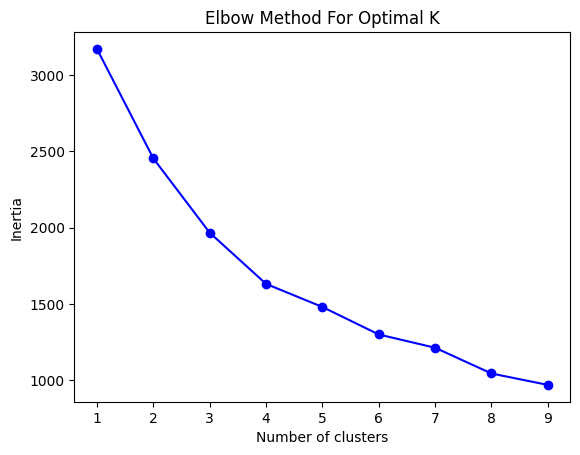

In [22]:
import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

Here we see that the optimal value of k from the graph above is when the value of inertia is the least. Hence optimal k value is 9.

Hence, we implement k-means clustering with k=9

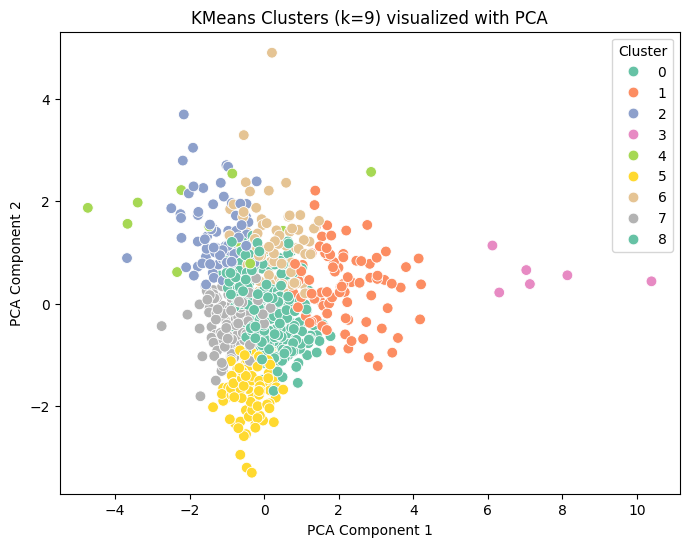

In [23]:
optimal_k = 9

kmeans = KMeans(n_clusters=9, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
customer_df['kmeans_cluster'] = kmeans_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set2', s=60)
plt.title(f'KMeans Clusters (k={optimal_k}) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

The clusters formed are not providing a good degree of separation between the points of each cluster. There is overlapping in points from a cluster. Hence, we modify the number of clusters to 3, to check for any changes in the clusters formed.

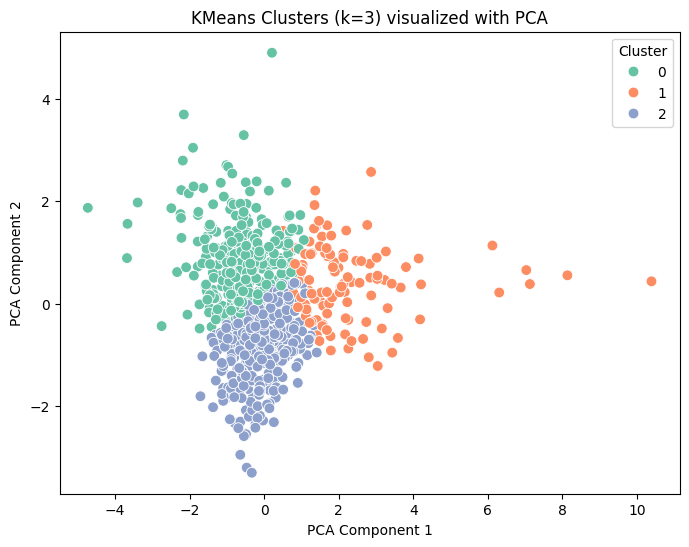

In [24]:
#Using no_clusters = 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
customer_df['kmeans_cluster'] = kmeans_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set2', s=60)
plt.title(f'KMeans Clusters (k={3}) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

Upon implementing k-means clustering with 3, we see a distinct group of cluster being formed with clear separatability among points.

DBSCAN Clustering

Assumption : n_neighbors = 5

Plotting graph to identify the optimal value of epsilon

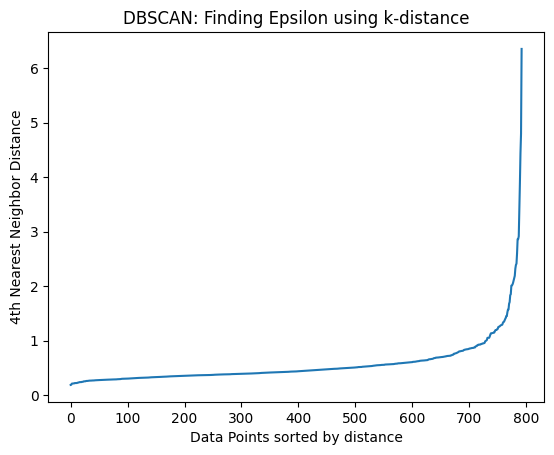

In [42]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 4], axis=0)

plt.plot(distances)
plt.title("DBSCAN: Finding Epsilon using k-distance")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()

Creating a loop to identfy the best params for DBSCAN

In [26]:
eps_values = [0.5, 1.0, 1.5,2.0, 2.5, 3, 3.5,4,4.5,5,5.5,6,6.5]
min_samples_values = [2,3, 4, 5,6,7,8,9, 10]

best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)


        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            continue

        try:
            score = silhouette_score(X, labels)
        except:
            score = -1

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"eps={eps}, min_samples={min_samples} => Clusters: {n_clusters}, Noise: {n_noise}, Silhouette: {score:.3f}")

        if score > best_score:
            best_score = score
            best_params = {
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette_score': score.round(3)
            }

print("\n Best Parameters Found:")
print(best_params)

eps=0.5, min_samples=2 => Clusters: 22, Noise: 127, Silhouette: -0.273
eps=0.5, min_samples=3 => Clusters: 6, Noise: 159, Silhouette: 0.085
eps=0.5, min_samples=4 => Clusters: 4, Noise: 184, Silhouette: -0.028
eps=0.5, min_samples=5 => Clusters: 6, Noise: 208, Silhouette: -0.136
eps=0.5, min_samples=6 => Clusters: 1, Noise: 247, Silhouette: 0.256
eps=0.5, min_samples=7 => Clusters: 1, Noise: 264, Silhouette: 0.245
eps=0.5, min_samples=8 => Clusters: 1, Noise: 281, Silhouette: 0.230
eps=0.5, min_samples=9 => Clusters: 1, Noise: 291, Silhouette: 0.220
eps=0.5, min_samples=10 => Clusters: 1, Noise: 309, Silhouette: 0.201
eps=1.0, min_samples=2 => Clusters: 4, Noise: 29, Silhouette: 0.264
eps=1.0, min_samples=3 => Clusters: 2, Noise: 33, Silhouette: 0.283
eps=1.0, min_samples=4 => Clusters: 1, Noise: 37, Silhouette: 0.534
eps=1.0, min_samples=5 => Clusters: 1, Noise: 38, Silhouette: 0.533
eps=1.0, min_samples=6 => Clusters: 1, Noise: 44, Silhouette: 0.516
eps=1.0, min_samples=7 => Clusters

We see te best params is observed for the scenario where only 1 cluster is formed. It is choosen by the set of params for which the silhouette score is the highest for the combination of epsilon and min_samples values

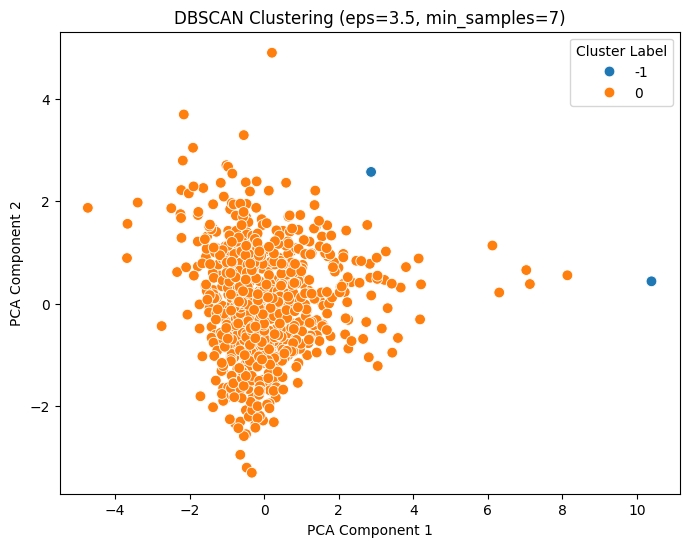

In [27]:
dbscan = DBSCAN(eps=3.5, min_samples=7)
labels = dbscan.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=60)
plt.title("DBSCAN Clustering (eps=3.5, min_samples=7)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster Label")
plt.show()

Since we observe only one cluster being formed, we can conclude DBSCAN is ineffective in customer segmentation for this dataset.

Guassian Mixture

Implementing a loop to identify the number of components for Guassian Mixture. The one with the least BIC score is the component count that is most optimal.

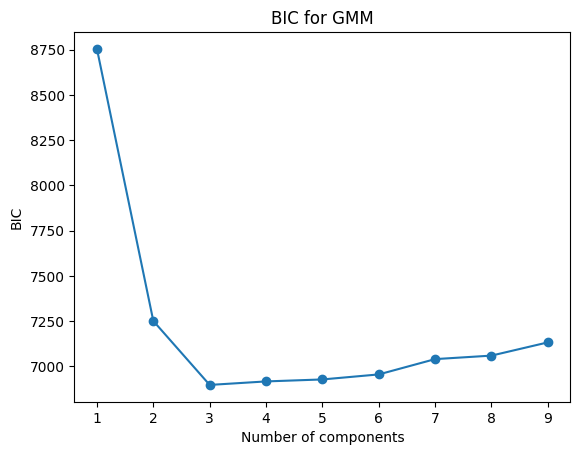

In [44]:
bic = []
n_components_range = range(1, 10)
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    bic.append(gmm.bic(X))

plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC for GMM')
plt.show()

For number_of_components = 3, the BIC score is the least. After which through the graph we can see a steady increase in BIC. Hence we choose n_components = 3

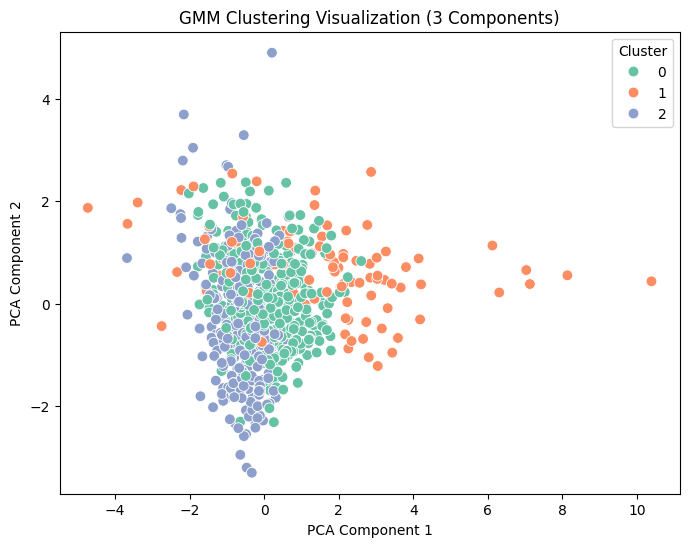

In [45]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)
customer_df['gmm_cluster'] = gmm_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='Set2', s=60)
plt.title("GMM Clustering Visualization (3 Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

Here we see 2 clusters are clearly formed while the 3rd cluster has no separabiilty from the points of the other clusters.

The clusters obtained from K-Means clustering and GMM are different. To evaluate the one with the best performance for the given dataset, we compute the silhoutte score for each.

In [46]:
# KMeans Silhouette Score
kmeans_score = silhouette_score(X, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_score:.3f}")

# GMM Silhouette Score
gmm_score = silhouette_score(X, gmm_labels)
print(f"GMM Silhouette Score: {gmm_score:.3f}")

KMeans Silhouette Score: 0.239
GMM Silhouette Score: 0.078


Since the Silhouette score for K-Means is greater than that for GMM, we choose K-Means for clustering.

In [47]:
customer_df['kmeans_cluster'] = kmeans_labels

In [48]:
cluster_summary = customer_df.groupby('kmeans_cluster').agg({
    'Sales': 'mean',
    'Profit': 'mean',
    'Discount': 'mean',
    'Quantity': 'mean'
}).reset_index()

In [49]:
print(cluster_summary)

   kmeans_cluster        Sales       Profit  Discount  Quantity
0               0  2374.768196   -21.140281  0.224210  4.186525
1               1  7680.420022  1637.751164  0.118309  3.977765
2               2  1934.268549   306.854617  0.113292  3.401722


In [50]:
def generate_dynamic_insights(cluster_summary):
    insights = []

    overall_avg_sales = cluster_summary['Sales'].mean()
    overall_avg_profit = cluster_summary['Profit'].mean()
    overall_avg_discount = cluster_summary['Discount'].mean()
    overall_avg_quantity = cluster_summary['Quantity'].mean()

    for idx, row in cluster_summary.iterrows():
        cluster_id = row['kmeans_cluster']
        total_sales = row['Sales']
        total_profit = row['Profit']
        cluster_avg_discount = row['Discount']
        cluster_avg_quantity = row['Quantity']


        sales_insight = "high" if total_sales > overall_avg_sales else "low"
        profit_insight = "high" if total_profit > overall_avg_profit else "low"
        discount_insight = "high" if cluster_avg_discount > overall_avg_discount else "low"
        quantity_insight = "high" if cluster_avg_quantity > overall_avg_quantity else "low"


        insight = f"Cluster {cluster_id}: \n" \
                  f"Sales: {sales_insight} , Profit: {profit_insight} , Discount: {discount_insight} , Quantity: {quantity_insight} . \n"

        if sales_insight == "high" and profit_insight == "high":
            insight += "This cluster represents high-value customers who generate substantial revenue and profit. Consider offering premium services or upselling opportunities."
        elif sales_insight == "low" and profit_insight == "low":
            insight += "This cluster has low engagement and is unprofitable. Focus on re-engaging these customers with promotions or incentives."
        elif discount_insight == "high" and profit_insight == "low":
            insight += "This cluster is highly discount-sensitive, but the business is losing money. Reduce discounting or introduce value-based pricing strategies."
        elif quantity_insight == "high":
            insight += "This cluster buys frequently. Consider offering loyalty rewards or volume-based discounts to increase retention."
        else:
            insight += "Consider tailoring offers based on customer preferences, such as limited-time promotions or personalized discounts."

        insights.append(insight)

    return "\n\n".join(insights)

In [51]:
insights = generate_dynamic_insights(cluster_summary)
print(insights)

Cluster 0.0: 
Sales: low , Profit: low , Discount: high , Quantity: high . 
This cluster has low engagement and is unprofitable. Focus on re-engaging these customers with promotions or incentives.

Cluster 1.0: 
Sales: high , Profit: high , Discount: low , Quantity: high . 
This cluster represents high-value customers who generate substantial revenue and profit. Consider offering premium services or upselling opportunities.

Cluster 2.0: 
Sales: low , Profit: low , Discount: low , Quantity: low . 
This cluster has low engagement and is unprofitable. Focus on re-engaging these customers with promotions or incentives.
